# Project: Predict Future Sale

The goal of this project is to predict the upcoming monthly sales of various items in various shops for an electronics retail company. 

The available training data are sale records in previous 34 months.

## This is Notebook I : Basic EDA, understand the train and test sets, data cleaning.

We divide this notebook into 4 parts:
- part 0: data cleaning.
- part I: understand and compare the train and test sets. 
- part II: study the target values in the train set.
- part III: tranform the train and test sets according to insight found in Part I and II.

In [3]:
import pandas as pd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import seaborn as sns

import pickle


## Load datas

In [4]:
# Load data: there are 5 csv files provided.
# besides 'train' and 'test' sets, 
#'items' appears to be a catalog of all items, 
#'item_cats' contains item categories.
#'shops' contains only 'shop_id', 'shop_name' 

folder = 'competitive-data-science-predict-future-sales/'

train = pd.read_csv(folder+'sales_train.csv')
test = pd.read_csv(folder+'test.csv').set_index('ID')
items = pd.read_csv(folder+'items.csv')
item_cats = pd.read_csv(folder+'item_categories.csv')
shops = pd.read_csv(folder+'shops.csv')


## Part 0. Basic data cleaning


In [5]:
# look at the shape of test set
test

,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268
...,...,...
214195,45,18454
214196,45,16188
214197,45,15757


In [6]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [7]:
train.dtypes

date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

In [8]:
# train.date was of dtype 'Object', transform it to 'datetime' for later analysis
train['date'] = pd.to_datetime(train.date)

In [9]:
# There are no obvious missing data (we shall look for other abnormalies later)
train.isna().sum(), test.isna().sum()

(date              0
 date_block_num    0
 shop_id           0
 item_id           0
 item_price        0
 item_cnt_day      0
 dtype: int64,
 shop_id    0
 item_id    0
 dtype: int64)

In [10]:
# Check if there is any duplicated rows in train

train[train.duplicated(keep=False)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
76961,2013-05-01,0,54,20130,149.0,1.0
76962,2013-05-01,0,54,20130,149.0,1.0
1435365,2014-02-23,13,50,3423,999.0,1.0
1435367,2014-02-23,13,50,3423,999.0,1.0
1496765,2014-03-23,14,21,3423,999.0,1.0
1496766,2014-03-23,14,21,3423,999.0,1.0
1671872,2014-01-05,16,50,3423,999.0,1.0
1671873,2014-01-05,16,50,3423,999.0,1.0
1866322,2014-12-07,18,25,3423,999.0,1.0
1866340,2014-12-07,18,25,3423,999.0,1.0


In [11]:
# if an item get sold multiple times on a same day, this should be reflected on 'item_cnt_day' (item count per day)
# rather than having multiple identical records. So these must be redundant.
# Delete duplicates.

train.drop(train[train.duplicated()].index, inplace=True)

In [12]:
# double check
train[train.duplicated()]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


## Part I. Main Question: How do train and test sets compare?

We saw that the raw test data only has two features: 'shop_id', 'item_id'. 

Let's look into the distributions of the these two features in train and test.

In [13]:
#How many unique values of the two features are in the test set?

len(test.shop_id.unique()), len(test.item_id.unique())

(42, 5100)

In [14]:
#How many unique values of the two features are in the test set?

len(train.shop_id.unique()), len(set(train.item_id.unique()))

(60, 21807)

In [15]:
# There is a big discrepancy.
# The dataset 'items' contains a catalog of all items, how many items are there?

len(items.item_id.unique())

22170

In [16]:
# look like some items may not appear in train or test set
# How many items are in 'test' but not in 'train'?

len(set(test.item_id.unique()).difference(set(train.item_id.unique())))

363

In [17]:
# There are 363 out of 4200 items in 'test' but not appear in 'train'
# Note: 363 + 21807 = 22170 !

items_intest_notintrain = set(test.item_id.unique()).difference(set(train.item_id.unique()))
len(items_intest_notintrain)+len(train.item_id.unique())

22170

In [18]:
# what is the distributions of the feature 'item_id' in 'test'?
test.item_id.value_counts(), test.item_id.value_counts().unique()

(2047     42
 19744    42
 15406    42
 13359    42
 3240     42
          ..
 21086    42
 21214    42
 17244    42
 21342    42
 2049     42
 Name: item_id, Length: 5100, dtype: int64,
 array([42]))

In [19]:
# each item appear exactly 42 times in 'test', which is the number of shops in 'test'
# the item distribution in 'train' is not as neat.

# what the distribution of shop id?
test.shop_id.value_counts().unique()

# 42 x 5100 = 214200, which the number of rows in 'test'. 

array([5100])

#### Therefore, the test set is simply "42 shops times 5100 items" !!







In [20]:


# what is the value counts of the feature 'item_id' in 'train'?
train.item_id.value_counts()

20949    31340
5822      9408
17717     9067
2808      7479
4181      6853
         ...  
593          1
13866        1
16574        1
20668        1
0            1
Name: item_id, Length: 21807, dtype: int64

In [21]:
# what is the value counts of the feature 'shop_id' in 'train'?
train.shop_id.value_counts()

31    235636
25    186103
54    143479
28    142234
57    117428
42    109252
27    105366
6      82663
58     71441
56     69573
46     66321
50     65171
19     63911
15     59511
35     58445
21     58132
7      58076
47     56695
26     53910
18     53227
24     53032
53     52921
16     52734
30     50860
29     49225
38     46013
22     45434
51     44433
52     43502
59     42108
41     41967
37     39638
44     39530
43     39282
4      38242
5      38179
14     36979
45     35891
55     34769
12     34694
2      25991
3      25532
17     22950
48     21612
10     21397
13     17824
49     15849
39     13440
0       9857
32      7947
23      6963
34      5752
1       5678
33      5027
40      4257
9       3751
8       3412
20      1792
11       499
36       306
Name: shop_id, dtype: int64

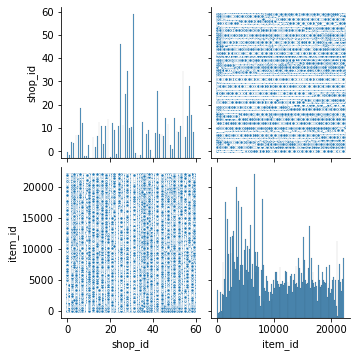

In [22]:

# Is there any visible relation btw 'shop_id' and 'item_id' in train set? Let's do a pairplot.
sns.pairplot(train[['shop_id','item_id']], markers = '.')

This plot confirms that the train set is not "shops x items", unlike the test set.

Since some items appear in 'test' do not appear in 'train', we cannot simply delete those items that are not in 'test'. Because otherwise, for those items in 'test' but not in 'train', we will probably have very little information to predict their sales.

#### We need to looking to 'item_category_id' to find more connection between train and test.

Question: there is a feature 'item_category_id' in 'item_cats', would 'item_category_id' in train set cover those in test set?

In [23]:
# dataframe 'items' contains features 'item_category_id', assigning a category_id for each item, 
# we shall add 'item_category_id' to 'train'
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [24]:
# dataframe 'item_cats' contains features 'item_category_name'

item_cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [25]:
# How many different categories are there?
len(item_cats.item_category_id.values)

84

In [26]:
# To help us understand the categories better, we translate the category_names into English

cat_names = ['PC - Headsets / Headphones', 
    'Accessories - PS2', 'Accessories - PS3',
    'Accessories - PS4', 'Accessories - PSP', 
    'Accessories - PSVita','Accessories - XBOX 360', 
    'Accessories - XBOX ONE', 'Tickets (Number)',
       'Delivery of goods', 'Game consoles - PS2',
       'Game consoles - PS3', 'Game consoles - PS4',
       'Game consoles - PSP', 'Game consoles - PSVita',
       'Game consoles - XBOX 360', 'Game consoles - XBOX ONE',
       'Game consoles - Other', 'Games - PS2', 'Games - PS3',
       'Games - PS4', 'Games - PSP', 'Games - PSVita', 'Games - XBOX 360',
       'Games - XBOX ONE', 'Games - Game Accessories',
       'Android Games - Number', 'MAC Games - Number',
       'PC Games - Additional Editions',
       "PC Games - Collector's Editions", "PC Games - Standard Editions",
       'PC Games - Number', 'Payment Cards (Cinema, Music, Games)',
       'Payment cards - Live!', 'Payment cards - Live! (Numeral)',
       'Payment cards - PSN', 'Payment cards - Windows (Digit)']+['Cinema - Blu-Ray', 'Cinema - Blu-Ray 3D', 'Cinema - Blu-Ray 4K',
       'Cinema - DVD', "Cinema - Collector's",
       'Books - Artbooks, encyclopedias', 'Books - Audiobooks',
       'Books - Audiobooks (Digital)', 'Books - Audiobooks 1C',
       'Books - Business Literature', 'Books - Comics, Manga',
       'Books - Computer Literature',
       'Books - Methodical materials 1C', 'Books - Postcards',
       'Books - Educational literature', 'Books - Guides',
       'Books - Fiction', 'Books - Number',
       'Music - locally produced CD',
       'Music - branded CD', 'Music - MP3']+['Music - Vinyl', 'Music - Music Video',
       'Music - Gift Editions', 'Gifts - Attributes',
       'Gifts - Gadgets, Robots, Sports', 'Gifts - Soft Toys',
       'Gifts - Board Games',
       'Gifts - Board Games (compact)',
       'Gifts - Cards, stickers', 'Gifts - Development',
       'Gifts - Certificates, services', 'Gifts - Souvenirs',
       'Gifts - Souvenirs (hinged)',
       'Gifts - Bags, Albums, Mouse Pads', 'Gifts - Figures',
       'Programs - 1C: Enterprise 8', 'Programs - MAC (Digit)']+['Programs - For Home and Office',
       'Programs - For Home and Office (Digital)', 'Programs - Educational',
       'Programs - Educational (Digital)', 'Service', 'Service - Tickets',
       'Blank media (spire)', 'Blank media (piece)',
       'Batteries']

item_cats['item_category_name'] = cat_names

In [27]:
# add 'item_category_id' from 'items' to 'train'
train = train.join(items.set_index('item_id'), on='item_id')
# 'item_cats' also contains a feature 'item_name', we shall get rid of it for now.
del train['item_name']

# add 'item_category_id' from 'items' to 'test'
test = test.join(items.set_index('item_id'), on='item_id')
del test['item_name']

In [28]:
# Also add 'item_category_name' from dataframe 'item_cats'

train = train.join(item_cats.set_index('item_category_id'), on= 'item_category_id')

test = test.join(item_cats.set_index('item_category_id'), on= 'item_category_id')

In [29]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,item_category_name
0,2013-02-01,0,59,22154,999.00,1.0,37,Cinema - Blu-Ray
1,2013-03-01,0,25,2552,899.00,1.0,58,Music - Vinyl
2,2013-05-01,0,25,2552,899.00,-1.0,58,Music - Vinyl
3,2013-06-01,0,25,2554,1709.05,1.0,58,Music - Vinyl
4,2013-01-15,0,25,2555,1099.00,1.0,56,Music - branded CD


In [30]:
test.head()

,shop_id,item_id,item_category_id,item_category_name
ID,,,,
0,5,5037,19,Games - PS3
1,5,5320,55,Music - locally produced CD
2,5,5233,19,Games - PS3
3,5,5232,23,Games - XBOX 360
4,5,5268,20,Games - PS4


In [31]:
# double check there are no 'NaN'
train.item_price.isna().sum()

0

In [32]:
# How many category_id are in train or test, respectively?

len(train.item_category_id.unique()), len(test.item_category_id.unique())

(84, 62)

#### All 84 categories show up in 'train', so definitely covers those 62 in 'test'. Good news!

(0.0, 10000.0)

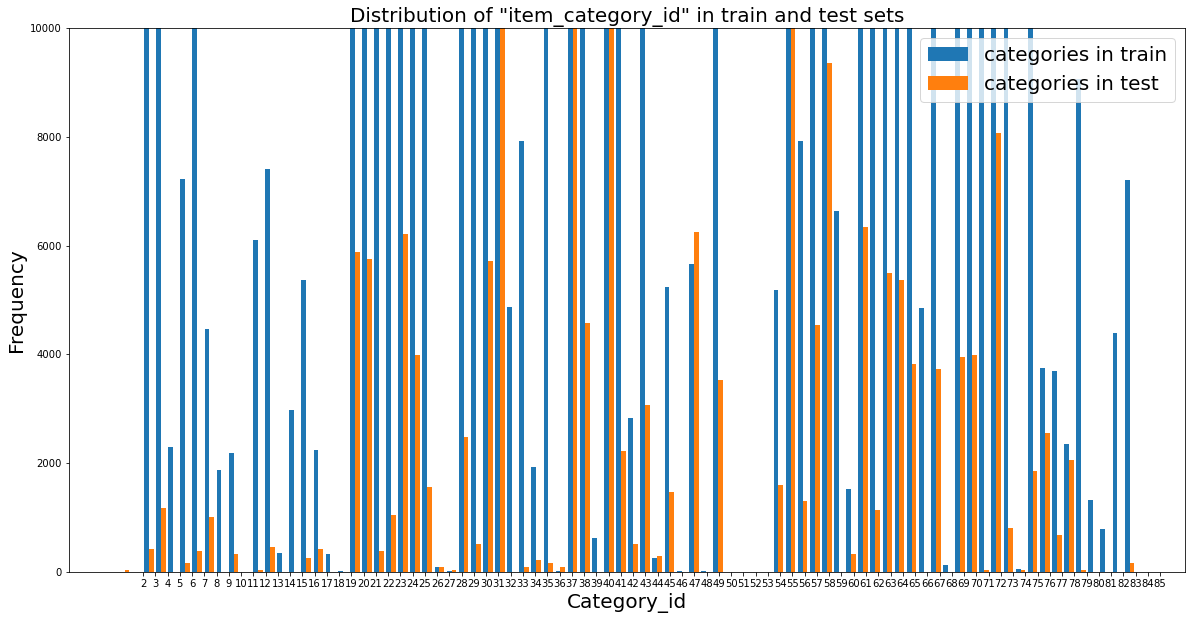

In [33]:
# How do the distributions of category_id in train and test sets look like?
# Plot a double-bar histogram of 'item_category_id' 

plt.figure(figsize=(20, 10))
plt.hist([train.item_category_id, test.item_category_id], bins = items.item_category_id.nunique(), label=['categories in train', 'categories in test'])
plt.title('Distribution of "item_category_id" in train and test sets', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.xticks(items.item_category_id.unique()+2)
plt.xlabel('Category_id', fontsize=20)
plt.legend(loc='upper right', fontsize=20)
plt.ylim([0,10000])

In [34]:
# In the plot above, there is a blank window from 50 to 53. 
# Take a look of what these are in 'train'
train[train.item_category_id.apply(lambda x: (x in [50,51,52,53]))]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,item_category_name
523877,2013-06-05,4,4,22110,100.0,1.0,52,Books - Guides
524200,2013-06-05,4,4,10696,100.0,1.0,52,Books - Guides
524274,2013-06-05,4,4,8435,100.0,1.0,52,Books - Guides
943693,2013-10-15,9,46,20273,199.0,1.0,53,Books - Fiction
1167339,2013-12-26,11,6,19700,299.0,1.0,53,Books - Fiction
1431097,2014-02-23,13,42,19701,349.0,1.0,53,Books - Fiction
1792133,2014-07-20,18,38,17703,129.0,1.0,51,Books - Educational literature
2532635,2015-05-03,26,10,16834,17.0,2.0,50,Books - Postcards
2532636,2015-05-03,26,10,16835,24.0,1.0,50,Books - Postcards


In [35]:
# what are all category_id's not in 'test'?

missing_cats = set(train.item_category_id.unique()).difference(set(test.item_category_id.unique()))
item_cats.iloc[list(missing_cats)]

,item_category_name,item_category_id
1,Accessories - PS2,1
4,Accessories - PSP,4
8,Tickets (Number),8
10,Game consoles - PS2,10
13,Game consoles - PSP,13
14,Game consoles - PSVita,14
17,Game consoles - Other,17
18,Games - PS2,18
32,"Payment Cards (Cinema, Music, Games)",32
39,Cinema - Blu-Ray 4K,39


Among all the missing categories, we conjecture that:
1. some of the categories, such as "xxx-PS2, xxx-PSP", are probably products that are out-of-date;
2. categories "Ticket(Number), Payment Cards， Blank" are isolated, may just delete them.

In [36]:
# select all trainning data whose category is not in 'test'
df_missing_cats = train[train.item_category_id.apply(lambda x: (x in list(missing_cats)))]

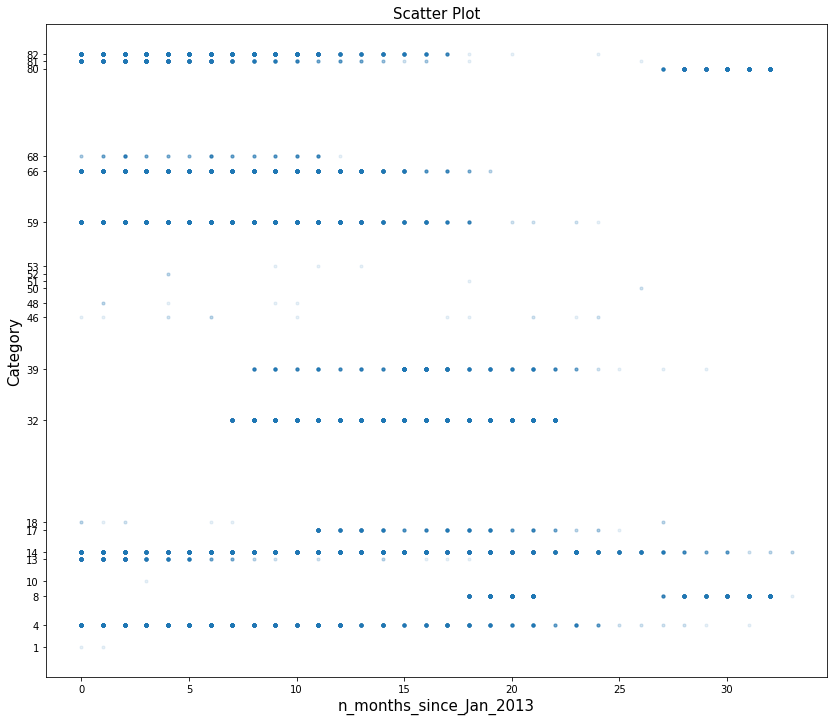

In [37]:
# Plot a scattering diagram to see the trend of these categories.

plt.figure(figsize=(14,12))
plt.scatter(df_missing_cats.date_block_num, df_missing_cats.item_category_id, marker='.', alpha=0.1)
plt.ylabel('Category',fontsize=15)
plt.yticks(df_missing_cats.item_category_id.unique())
plt.xlabel('n_months_since_Jan_2013',fontsize=15)
plt.title('Scatter Plot',fontsize=15)
plt.show()

The above plot basically confirm our conjecture for all missing categories, namely, these categories are either out-of-date products or standalone items.

We may just delete all these categories.

In [38]:
# Delete these redundant categories from train set.
train.drop(df_missing_cats.index, inplace=True)

In [39]:
# check out the numbers of items and categories in the reduced train set.
train.shape, train.item_id.nunique(), train.item_category_id.nunique()

((2904358, 8), 21184, 62)

#### On the other hand, let's look at those 363 in-test-not-in-train items, and then their categories presence in 'train'


In [40]:
def item_to_cat(itemarray):
    """input an array of item_id's, return an array of corresponding category_id's"""
    itemarray = np.array(itemarray)
    return items.loc[itemarray].item_category_id.unique()

# get the category_id of those 363 in-test-not-in-train items
cat_intest_notintrain = item_to_cat(items_intest_notintrain)

In [41]:
df_intest_notintrain = train[train.item_category_id.apply(lambda x:(x in cat_intest_notintrain))]

In [42]:
# the rows that have category_id in cat_intest_notintrain are the Majority!
df_intest_notintrain

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,item_category_name
0,2013-02-01,0,59,22154,999.00,1.0,37,Cinema - Blu-Ray
1,2013-03-01,0,25,2552,899.00,1.0,58,Music - Vinyl
2,2013-05-01,0,25,2552,899.00,-1.0,58,Music - Vinyl
3,2013-06-01,0,25,2554,1709.05,1.0,58,Music - Vinyl
4,2013-01-15,0,25,2555,1099.00,1.0,56,Music - branded CD
...,...,...,...,...,...,...,...,...
2935843,2015-09-10,33,25,7409,299.00,1.0,55,Music - locally produced CD
2935844,2015-10-10,33,25,7409,299.00,1.0,55,Music - locally produced CD
2935845,2015-09-10,33,25,7460,299.00,1.0,55,Music - locally produced CD
2935846,2015-10-14,33,25,7459,349.00,1.0,55,Music - locally produced CD


### Question to think about later: how do we extract new features to facilitate the prediction of sales for the 363 missing/newly-added iterms?

## Part II. Main question: what is the distribution of the target values (y_train)?

#### We are going to predict sale by month, train set is given with sale by day, so first let's aggregate.

In [43]:
list(train.columns)

['date',
 'date_block_num',
 'shop_id',
 'item_id',
 'item_price',
 'item_cnt_day',
 'item_category_id',
 'item_category_name']

In [44]:
# groupby (month, shop_id, item_id)
train_mo = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_category_id':'mean', 'item_cnt_day':'sum'})

In [45]:
train_mo.reset_index(inplace=True)

In [46]:
train_mo.rename(columns={'item_cnt_day': 'item_cnt'}, inplace=True)

In [47]:
train_mo

,date_block_num,shop_id,item_id,item_category_id,item_cnt
0,0,0,32,40,6.0
1,0,0,33,37,3.0
2,0,0,35,40,1.0
3,0,0,43,40,1.0
4,0,0,51,57,2.0
...,...,...,...,...,...
1592977,33,59,22087,83,6.0
1592978,33,59,22088,83,2.0
1592979,33,59,22091,83,1.0
1592980,33,59,22100,42,1.0


In [119]:
# numbers of shop_id and item_id in train_mo
train_mo.shop_id.nunique(), train_mo.item_id.nunique()

(60, 21184)

### Analyze the distribution of the target: 'item_cnt'

In [49]:
# what is the range of 'item_cnt'
train_mo.item_cnt.values.min(), train_mo.item_cnt.values.max()

(-13.0, 2253.0)

In [50]:
# let's the rows that have 'item_cnt'>2000, it turns out has only one row.
train_mo[train_mo.item_cnt>2000]

,date_block_num,shop_id,item_id,item_category_id,item_cnt
1565987,33,12,11373,9,2253.0


In [51]:
# rows that have negative 'item_cnt'
train_mo[train_mo.item_cnt<0]

,date_block_num,shop_id,item_id,item_category_id,item_cnt
5716,0,4,12211,62,-1.0
7176,0,6,12283,62,-1.0
10827,0,12,1590,29,-13.0
10828,0,12,1592,23,-1.0
10829,0,12,1593,29,-6.0
...,...,...,...,...,...
1574824,33,26,10513,38,-1.0
1575139,33,26,21363,41,-1.0
1578889,33,34,7233,3,-1.0
1586293,33,48,2860,25,-1.0


In [122]:
# because the scale of frequency for different 'item_cnt' values differs by a lot, 
# plotting a histogram with all 'item_cnt' values will not reveal much information.

# So we define a function that will plot histogram on multiple given ranges, 
# and use it to plot piecewise histograms for 'item_cnt'.

def plot_piecewise_hist(rangelist, data=train_mo.item_cnt):
    """
    inputs: 
    a list or listable of 2-d arrays, e.g. [(-13,-1),(-1,1)]
    
    data for the histogram, a pd.Series or alike, default = train_mo.item_cnt
    
    output: histogram plots of item_cnt for each given range
    """
    rangelist = list(rangelist)
    n = len(rangelist)
    if n>0:
        # create a subplots
        fig, ax = plt.subplots(n,1, figsize=(6, 4*n))
        fig.suptitle("Histograms of 'item_cnt' on different ranges")
        for idx, rng in enumerate(rangelist):

            # plot the histogram
            ax[idx].hist(data, range=rng)
            ax[idx].set_xlabel('Range')
            ax[idx].set_ylabel('Frequency')
        
            
    else:
        print('Length of rangelist cannot be 0.')
                       

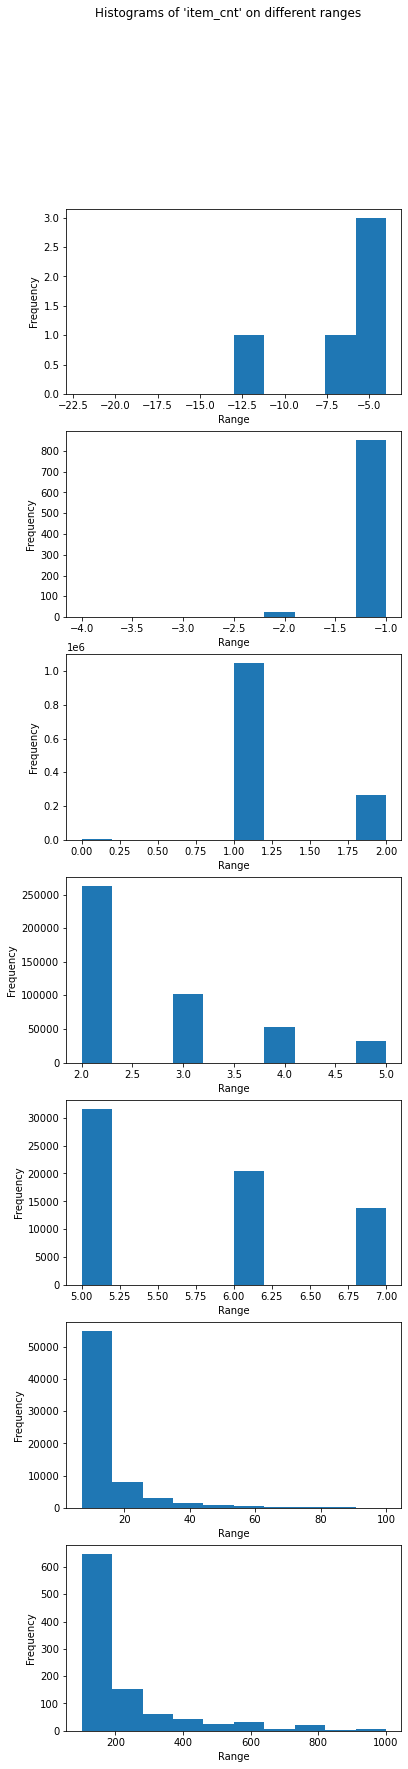

In [123]:
rangelist = [(-22,-4),(-4,-1),(0,2),(2,5),(5,7),(7,100),(100,1000)]
plot_piecewise_hist(rangelist)

From the piecewise histgorams above, we learned that 
- on [1,1000], item_cnt decays exponentially, or even more. 
- on the negative ends, it seems increasing exponentially, but that number of data is very small compare to the whole dataset.
- there is only a small number of zeros.

First, let's think about the number of zeros.

we have only a small number of zeros in 'train_mo'.
And there is not zeros in the original 'train'. (The small number of zeros in 'train_mo' comes from the aggregation.)

In [115]:
# what is the number of zeros 'item_cnt_day' in 'train'?

train[train.item_cnt_day==0].item_cnt_day.count()

0

In [118]:
# What is the fraction: number of rows in 'train_mo' / num_shop * num_item * num_month?

train_mo.shape[0]/(train_mo.shop_id.nunique()*train_mo.item_id.nunique()*34)

0.036861477030389195

This is because 'train' only contains sale records. If an item was not sold in a shop, it will not show up.
In fact, the above fraction shows that for most of the "(shop, item)" combinations, the sale number, i.e., the target value, is 0!

As the test set is of the form "42 shops time 5100 items", we should add these "missing" zeros in our 'train_mo', to make it resembles what the test set target would look like.

### Add zeros to those (shop, item) combinations that have 0 sales.

In [284]:
train_mo

,date_block_num,shop_id,item_id,item_category_id,item_cnt
0,0,0,32,40,6.0
1,0,0,33,37,3.0
2,0,0,35,40,1.0
3,0,0,43,40,1.0
4,0,0,51,57,2.0
...,...,...,...,...,...
1592977,33,59,22087,83,6.0
1592978,33,59,22088,83,2.0
1592979,33,59,22091,83,1.0
1592980,33,59,22100,42,1.0


In [135]:
# first we create a dataframe 'train_zero' consists of all_month x all_shops x all_items.

array_shops = sorted(train_mo.shop_id.unique())
df_items = pd.DataFrame(sorted(train_mo.item_id.unique()),columns=['item_id'])

In [136]:
shop_item = pd.DataFrame()
for shop in array_shops:
        temp = df_items.copy()
        temp['shop_id'] = shop
        shop_item = pd.concat([shop_item, temp], axis=0)

In [137]:
train_zero = pd.DataFrame()        
for num in sorted(train_mo.date_block_num.unique()):
    temp = shop_item.copy()
    temp['date_block_num'] = num
    train_zero = pd.concat([train_zero, temp])
    

In [138]:
train_zero.reset_index(drop=True)

,item_id,shop_id,date_block_num
0,0,0,0
1,1,0,0
2,2,0,0
3,3,0,0
4,4,0,0
...,...,...,...
43215355,22165,59,33
43215356,22166,59,33
43215357,22167,59,33
43215358,22168,59,33


In [139]:
# then we join 'train_zero' and 'train_mo' on ('item_id','shop_id','date_block_num')
# to get the desired dataset 'train_all'
train_all = train_zero.join(train_mo.set_index(['item_id','shop_id','date_block_num']), on=['item_id','shop_id','date_block_num'], how='left')

In [142]:
# fill in zeros for 'item_cnt' in train_all !!
train_all.item_cnt.fillna(0, inplace=True)

In [143]:
dict_item_to_cat = items[['item_id','item_category_id']].set_index('item_id').to_dict()['item_category_id']

dict_item_to_cat

{0: 40,
 1: 76,
 2: 40,
 3: 40,
 4: 40,
 5: 40,
 6: 40,
 7: 40,
 8: 40,
 9: 40,
 10: 40,
 11: 40,
 12: 55,
 13: 40,
 14: 40,
 15: 40,
 16: 40,
 17: 40,
 18: 40,
 19: 40,
 20: 40,
 21: 40,
 22: 40,
 23: 40,
 24: 40,
 25: 40,
 26: 40,
 27: 19,
 28: 30,
 29: 23,
 30: 40,
 31: 37,
 32: 40,
 33: 37,
 34: 40,
 35: 40,
 36: 37,
 37: 40,
 38: 41,
 39: 41,
 40: 57,
 41: 57,
 42: 57,
 43: 40,
 44: 57,
 45: 57,
 46: 57,
 47: 57,
 48: 57,
 49: 57,
 50: 57,
 51: 57,
 52: 57,
 53: 57,
 54: 57,
 55: 43,
 56: 57,
 57: 57,
 58: 78,
 59: 57,
 60: 43,
 61: 43,
 62: 37,
 63: 40,
 64: 40,
 65: 37,
 66: 37,
 67: 40,
 68: 30,
 69: 54,
 70: 49,
 71: 37,
 72: 40,
 73: 40,
 74: 37,
 75: 40,
 76: 37,
 77: 40,
 78: 40,
 79: 40,
 80: 37,
 81: 40,
 82: 37,
 83: 40,
 84: 40,
 85: 37,
 86: 40,
 87: 37,
 88: 40,
 89: 40,
 90: 40,
 91: 37,
 92: 37,
 93: 43,
 94: 40,
 95: 40,
 96: 40,
 97: 40,
 98: 40,
 99: 37,
 100: 40,
 101: 78,
 102: 76,
 103: 76,
 104: 76,
 105: 30,
 106: 30,
 107: 44,
 108: 44,
 109: 57,
 110: 44,


In [144]:
# fillin category_id for 'train_all'
train_all['item_category_id'] = train_all['item_id'].map(dict_item_to_cat)

In [152]:
train_all.reset_index(drop=True, inplace=True)

In [156]:
# double check that there is no 'Nan'
train_all.isna().sum()

item_id             0
shop_id             0
date_block_num      0
item_category_id    0
item_cnt            0
dtype: int64

In [157]:
# finding the CDF (cumulated distribution function) for the target 'item_cnt' in 'train_all'
new_sale_num_cumsum = pd.DataFrame(train_all.item_cnt.value_counts().sort_index().cumsum())
new_sale_num_cumperc = round((new_sale_num_cumsum/new_sale_num_cumsum.item_cnt.max())*100, 6)

new_sale_num_cumperc[new_sale_num_cumperc.index<21]

,item_cnt
-13.0,0.000002
-6.0,0.000005
-5.0,0.000007
-4.0,0.000012
-2.0,0.000067
-1.0,0.002036
0.0,96.321785
1.0,98.748234
2.0,99.357027
3.0,99.593594


In [158]:
# finding the PDF (Probability density function, in %) of the target values 'item_cnt' in 'train_all'

new_sale_num = pd.DataFrame(train_all.item_cnt.value_counts().sort_index())
new_sale_num_perc = round((new_sale_num/new_sale_num_cumsum.item_cnt.max())*100, 12)
new_sale_num_perc[new_sale_num_perc.index<21]

,item_cnt
-13.0,0.000002
-6.0,0.000002
-5.0,0.000002
-4.0,0.000005
-2.0,0.000056
-1.0,0.001969
0.0,96.319748
1.0,2.426450
2.0,0.608793
3.0,0.236566


<AxesSubplot:>

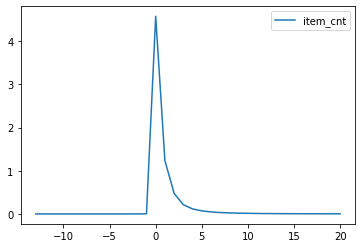

In [159]:
# Plot the log1p(density function)
new_sale_num_perc[:20].apply(np.log1p).plot()

These plots show that the distribution of the target 'item_cnt' concentrated at y=0, and decay extremely fast along the two wings. As the probability of seeing a negative or large sale number is extremely small, keeping them in the trainning set may actually do more harm than good, as if they are outliers.

#### So we should restrict trainning data to [1%, 99%] percentile.

In [163]:
# discard data with target value less than 0 or greater than 19.
train_clip = train_all[(train_all.item_cnt<20) & (train_all.item_cnt >-1)]

In [164]:
# value count the new trainning set
train_clip.item_cnt.value_count()

0.0     41624926
1.0      1048599
2.0       263092
3.0       102233
4.0        52716
5.0        31614
6.0        20482
7.0        13878
8.0        10275
9.0         7421
10.0        5922
11.0        4409
12.0        3648
13.0        3005
14.0        2414
15.0        2040
16.0        1727
17.0        1550
18.0        1277
19.0        1088
Name: item_cnt, dtype: int64

In [166]:
train_clip

,item_id,shop_id,date_block_num,item_category_id,item_cnt
0,0,0,0,40,0.0
1,1,0,0,76,0.0
2,2,0,0,40,0.0
3,3,0,0,40,0.0
4,4,0,0,40,0.0
...,...,...,...,...,...
43215355,22165,59,33,31,0.0
43215356,22166,59,33,54,0.0
43215357,22167,59,33,49,0.0
43215358,22168,59,33,62,0.0


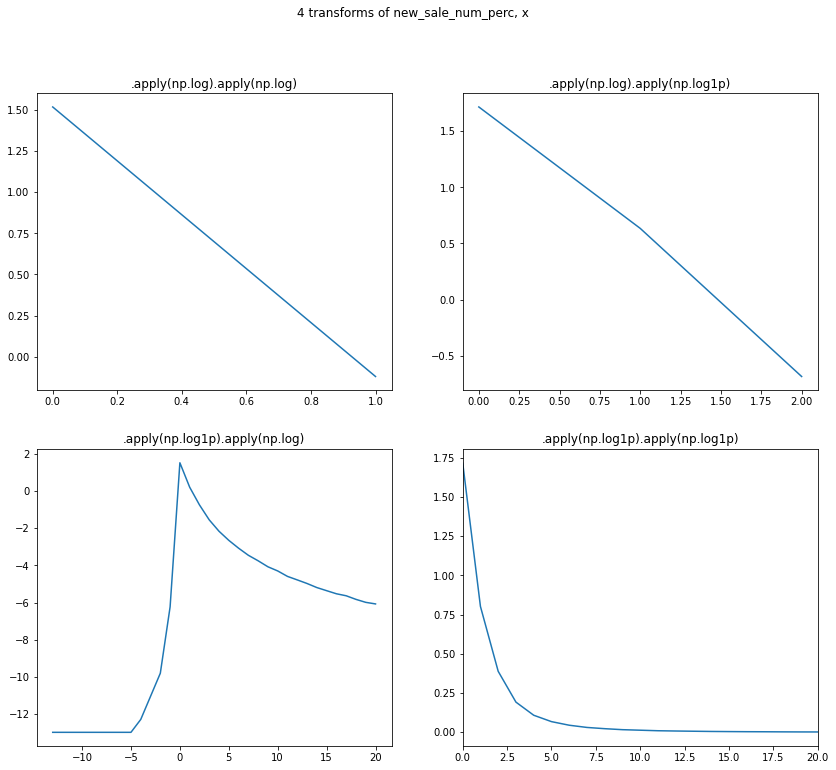

In [161]:

fig, ax = plt.subplots(2,2, figsize= (14, 12))

ax[0][0].plot(new_sale_num_perc[:20].apply(np.log).apply(np.log))
ax[0][1].plot(new_sale_num_perc[:20].apply(np.log).apply(np.log1p))
ax[1][0].plot(new_sale_num_perc[:20].apply(np.log1p).apply(np.log))
ax[1][1].plot(new_sale_num_perc[:20].apply(np.log1p).apply(np.log1p))

ax[0][0].set_title('.apply(np.log).apply(np.log)')
ax[0][1].set_title('.apply(np.log).apply(np.log1p)')
ax[1][0].set_title('.apply(np.log1p).apply(np.log)')
ax[1][1].set_title('.apply(np.log1p).apply(np.log1p)')
plt.suptitle('4 transforms of new_sale_num_perc, x ')
plt.xlim((0,20))

plt.show()

In [315]:
new_sale_num_perc[:20].apply(np.log).apply(np.log1p)

,item_cnt
-4.0,NaN
-2.0,NaN
-1.0,NaN
0.0,1.711123
1.0,0.873228
2.0,0.195756
3.0,-1.058853
4.0,NaN
5.0,NaN
6.0,NaN


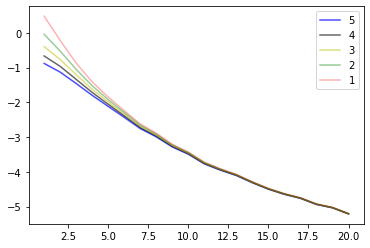

In [323]:
plt.plot(new_sale_num_perc[1:20].apply(np.log1p).apply(np.log1p).apply(np.log1p).apply(np.log1p).apply(np.log1p).apply(np.log), c='b',alpha=0.7,label='5')
plt.plot(new_sale_num_perc[1:20].apply(np.log1p).apply(np.log1p).apply(np.log1p).apply(np.log1p).apply(np.log), c='k',alpha=0.6, label='4')
plt.plot(new_sale_num_perc[1:20].apply(np.log1p).apply(np.log1p).apply(np.log1p).apply(np.log), c='y',alpha=0.5, label='3')
plt.plot(new_sale_num_perc[1:20].apply(np.log1p).apply(np.log1p).apply(np.log), c='g',alpha=0.4, label='2')
plt.plot(new_sale_num_perc[1:20].apply(np.log1p).apply(np.log), c='r',alpha=0.3, label='1')
plt.legend()
plt.show()

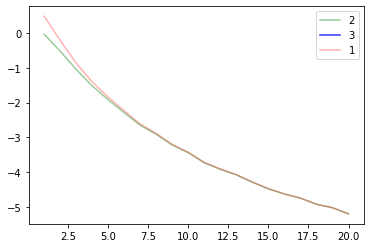

In [326]:
plt.plot(new_sale_num_perc[1:20].apply(np.log1p).apply(np.log1p).apply(np.log), c='g',alpha=0.4, label='2')
plt.plot(new_sale_num_perc[1:20].apply(np.log1p).apply(np.log).apply(np.log), c='b',alpha=0.8, label='3')
plt.plot(new_sale_num_perc[1:20].apply(np.log1p).apply(np.log), c='r',alpha=0.3, label='1')
plt.legend()

0.0     9700638
1.0      419643
2.0      129154
3.0       54143
4.0       28726
5.0       17773
6.0       11688
7.0        7861
8.0        5958
9.0        4304
10.0       3430
11.0       2546
12.0       2105
13.0       1789
14.0       1442
15.0       1191
16.0       1023
17.0        909
18.0        760
19.0        688
Name: item_cnt, dtype: int64

### add 'date_block_num' and 'item_category_id' to test set

In [168]:
test['date_block_num'] = 34

In [169]:
test['item_category_id'] = test['item_id'].map(dict_item_to_cat)

In [172]:
test

,shop_id,item_id,item_category_id,date_block_num
ID,,,,
0,5,5037,19,34
1,5,5320,55,34
2,5,5233,19,34
3,5,5232,23,34
4,5,5268,20,34
...,...,...,...,...
214195,45,18454,55,34
214196,45,16188,64,34
214197,45,15757,55,34


In [179]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,item_category_name
0,2013-02-01,0,59,22154,999.00,1.0,37,Cinema - Blu-Ray
1,2013-03-01,0,25,2552,899.00,1.0,58,Music - Vinyl
2,2013-05-01,0,25,2552,899.00,-1.0,58,Music - Vinyl
3,2013-06-01,0,25,2554,1709.05,1.0,58,Music - Vinyl
4,2013-01-15,0,25,2555,1099.00,1.0,56,Music - branded CD
...,...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0,55,Music - locally produced CD
2935845,2015-09-10,33,25,7460,299.00,1.0,55,Music - locally produced CD
2935846,2015-10-14,33,25,7459,349.00,1.0,55,Music - locally produced CD
2935847,2015-10-22,33,25,7440,299.00,1.0,57,Music - MP3


## Save datas for later use

In [175]:
# save the dataframe 'train_clip' as '1_train.pickle'
with open('1_train.pickle', 'wb') as f_train:
    pickle.dump(train_clip, f_train)

In [178]:
# save the dataframe 'test'
with open('1_test.pickle', 'wb') as f_test:
    pickle.dump(test, f_test)

In [180]:
# also save the original 'train' as "1_raw_train" for time series and other analysis later.
with open('1_raw_train.pickle','wb') as f_raw:
    pickle.dump(train, f_raw)